In [ ]:
!pip install pyod

In [ ]:
pip install catboost

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.manifold import TSNE
from tqdm import tqdm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe
import time
import datetime
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/My Drive/zindi/Train.csv", index_col='user_id')
test = pd.read_csv("/content/drive/My Drive/zindi/Test.csv", index_col='user_id')

In [ ]:
#из eda стало понятно, что те пользователи, у которых много пропусков в данных, скорее всего уйдут.
#создадим признак  
y = train['CHURN']
train = train.drop(columns=['CHURN'], axis=1)
for i in train.columns:
    train[i+'_nan'] = np.where(train[i].isna(), 1, 0)
    test[i+'_nan'] = np.where(test[i].isna(), 1, 0)
test

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,REGION_nan,TENURE_nan,MONTANT_nan,FREQUENCE_RECH_nan,REVENUE_nan,ARPU_SEGMENT_nan,FREQUENCE_nan,DATA_VOLUME_nan,ON_NET_nan,ORANGE_nan,TIGO_nan,ZONE1_nan,ZONE2_nan,MRG_nan,REGULARITY_nan,TOP_PACK_nan,FREQ_TOP_PACK_nan
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,THIES,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,NaN,378.0,11.0,5.0,NaN,NaN,NO,42,On-net 1000F=10MilF;10d,5.0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
000055d41c8a62052dd426592e8a4a3342bf565d,NaN,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,NaN,0.0,NaN,NaN,NaN,NO,41,"Data: 100 F=40MB,24H",1.0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0
000081dd3245e6869a4a9c574c7050e7bb84c2c8,DAKAR,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,NaN,NaN,NO,57,"Data: 100 F=40MB,24H",22.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
0000b76d2145d9445d9ff6b65c9ebc4196c89337,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,9,NaN,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
0000bae5480628cf8fe51ad84bcb39772fc79224,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,10,NaN,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe7e03c7eede2ad0a728ee516c4d342dd16107,DAKAR,K > 24 month,4000.0,8.0,3999.0,1333.0,8.0,1587.0,26.0,250.0,1.0,NaN,NaN,NO,53,Mixt 250F=Unlimited_call24H,5.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
fffec230e6a1aa51ab37d0051ece42de611e71c6,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
ffff0dcc1ab9812bf205b6d76e9d084053cd96f5,NaN,K > 24 month,3950.0,7.0,3949.0,1316.0,10.0,1724.0,25.0,71.0,NaN,NaN,NaN,NO,15,IVR Echat_Daily_50F,6.0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0


In [ ]:
#обработаем данные фичи
cat_feat = ["REGION", 'TENURE',"TOP_PACK"]
cont_feat = ['MONTANT','FREQUENCE_RECH','REVENUE','ARPU_SEGMENT','FREQUENCE','DATA_VOLUME','ON_NET',
                      'ORANGE','TIGO','ZONE1','ZONE2','REGULARITY','FREQ_TOP_PACK']
for col in cont_feat:
    train[col].fillna((train[col].median()), inplace=True)
    test[col].fillna((test[col].median()), inplace=True)

df = pd.concat([train, test], ignore_index = False)
for col in cat_feat:
    df[col].fillna('UNKNOWN', inplace=True)

le = LabelEncoder()
df["TOP_PACK"] = le.fit_transform(df["TOP_PACK"])
# df["TENURE"] = le.fit_transform(df["TENURE"])
# df["REGION"] = le.fit_transform(df["REGION"])
df = df.drop(columns = ["MRG"],axis=1)
df = pd.get_dummies(df)

In [ ]:
train = df.iloc[0:train.shape[0]]
test = df.iloc[train.shape[0]:]
del df

In [ ]:
train.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,TOP_PACK,FREQ_TOP_PACK,REGION_nan,TENURE_nan,MONTANT_nan,FREQUENCE_RECH_nan,REVENUE_nan,ARPU_SEGMENT_nan,FREQUENCE_nan,DATA_VOLUME_nan,ON_NET_nan,ORANGE_nan,TIGO_nan,ZONE1_nan,ZONE2_nan,MRG_nan,REGULARITY_nan,TOP_PACK_nan,FREQ_TOP_PACK_nan,REGION_DAKAR,REGION_DIOURBEL,REGION_FATICK,REGION_KAFFRINE,REGION_KAOLACK,REGION_KEDOUGOU,REGION_KOLDA,REGION_LOUGA,REGION_MATAM,REGION_SAINT-LOUIS,REGION_SEDHIOU,REGION_TAMBACOUNDA,REGION_THIES,REGION_UNKNOWN,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,109,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000cb4a5d760de88fecb38e2f71b7bec52e834,3000.0,7.0,3000.0,1000.0,9.0,257.0,27.0,29.0,6.0,1.0,2.0,4,128,5.0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
00001654a9d9f96303d9969d0a4a851714a4bb57,3600.0,2.0,1020.0,340.0,2.0,257.0,90.0,46.0,7.0,1.0,2.0,17,110,1.0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
00001dd6fa45f7ba044bd5d84937be464ce78ac2,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,1.0,2.0,62,35,11.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
000028d9e13a595abe061f9b58f3d76ab907850f,1000.0,1.0,985.0,328.0,1.0,257.0,39.0,24.0,6.0,1.0,2.0,11,102,2.0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Outliers

In [ ]:
#не дало ничего хорошего
mask = train.sample(500000).index
clf_name = 'PCA'
clf = PCA()
clf.fit(train.loc[mask].drop('CHURN', axis=1))

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  

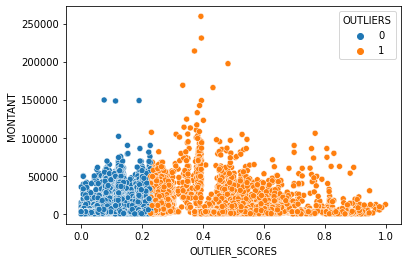

In [ ]:
sns.scatterplot(data=X_train, x='OUTLIER_SCORES', y='MONTANT', hue='OUTLIERS')

In [ ]:
#Применим логарифм к неприрывных признакам
train[cont_feat] = np.log1p(train[cont_feat])
test[cont_feat] = np.log1p(test[cont_feat])

In [ ]:
#Скорее всего, чем больше значение признака, тем больше клиент пользуется продуктом компании и он остается в компании
#Создадим признак, входит ли значение в 99 квантиль
numerical_cols = train.columns[train.dtypes=='float']
train[[x + '_OUTLIER' for x in numerical_cols]] = (
    train[numerical_cols] > train[numerical_cols].quantile(0.99)
).astype('int')

test[[x + '_OUTLIER' for x in numerical_cols]] = (
    test[numerical_cols] > train[numerical_cols].quantile(0.99)
).astype('int')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size = 0.2,random_state=2)
# scaler = StandardScaler()
# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])
# test[numerical_features] = scaler.transform(test[numerical_features])

In [ ]:
N_FOLDS = 5
kf = KFold(n_splits = N_FOLDS)
oof = np.zeros(len(y))
#preds_folds = np.zeros(len(test))
for train_ind, test_ind in tqdm(kf.split(train)):
    X_train = train.iloc[train_ind]
    X_val = train.iloc[test_ind]
    y_train = y.iloc[train_ind]
    y_val = y.iloc[test_ind]
    model_cat = CatBoostClassifier(**params_cat)
    model_cat.fit(X_train, y_train, eval_set=[(X_val,y_val)], verbose=100,early_stopping_rounds=150,use_best_model=True)
    p = model_cat.predict_proba(X_val)[:, 1]
    oof[test_ind] = p
    #preds_folds += model.predict(test)/N_FOLDS
    print(roc_auc_score(y_val, p))
print(roc_auc_score(y, oof))

0it [00:00, ?it/s]

0:	learn: 0.9262196	test: 0.9261329	best: 0.9261329 (0)	total: 122ms	remaining: 2m 38s
100:	learn: 0.9310759	test: 0.9309148	best: 0.9309148 (100)	total: 9.2s	remaining: 1m 49s
200:	learn: 0.9314819	test: 0.9311693	best: 0.9311695 (199)	total: 18s	remaining: 1m 38s
300:	learn: 0.9317295	test: 0.9312918	best: 0.9312919 (299)	total: 26.7s	remaining: 1m 28s
400:	learn: 0.9319345	test: 0.9313698	best: 0.9313698 (400)	total: 35.4s	remaining: 1m 19s
500:	learn: 0.9321090	test: 0.9314119	best: 0.9314134 (497)	total: 44.1s	remaining: 1m 10s
600:	learn: 0.9322627	test: 0.9314364	best: 0.9314368 (589)	total: 52.7s	remaining: 1m 1s
700:	learn: 0.9324062	test: 0.9314512	best: 0.9314526 (699)	total: 1m 1s	remaining: 52.4s
800:	learn: 0.9325328	test: 0.9314621	best: 0.9314629 (797)	total: 1m 10s	remaining: 43.6s
900:	learn: 0.9326592	test: 0.9314696	best: 0.9314725 (852)	total: 1m 18s	remaining: 34.8s
1000:	learn: 0.9327808	test: 0.9314841	best: 0.9314864 (988)	total: 1m 27s	remaining: 26.1s
1100:	l

1it [01:53, 113.25s/it]

0.931494055132359
0:	learn: 0.9264196	test: 0.9258578	best: 0.9258578 (0)	total: 111ms	remaining: 2m 24s
100:	learn: 0.9311434	test: 0.9305671	best: 0.9305671 (100)	total: 9.13s	remaining: 1m 48s
200:	learn: 0.9315583	test: 0.9308693	best: 0.9308693 (200)	total: 17.9s	remaining: 1m 38s
300:	learn: 0.9318102	test: 0.9309959	best: 0.9309959 (300)	total: 26.6s	remaining: 1m 28s
400:	learn: 0.9320177	test: 0.9310725	best: 0.9310725 (400)	total: 35.3s	remaining: 1m 19s
500:	learn: 0.9321969	test: 0.9311159	best: 0.9311159 (500)	total: 43.9s	remaining: 1m 10s
600:	learn: 0.9323503	test: 0.9311437	best: 0.9311437 (600)	total: 52.6s	remaining: 1m 1s
700:	learn: 0.9324967	test: 0.9311636	best: 0.9311637 (698)	total: 1m 1s	remaining: 52.3s
800:	learn: 0.9326244	test: 0.9311728	best: 0.9311737 (775)	total: 1m 9s	remaining: 43.5s
900:	learn: 0.9327486	test: 0.9311797	best: 0.9311800 (896)	total: 1m 18s	remaining: 34.8s
1000:	learn: 0.9328696	test: 0.9311887	best: 0.9311887 (1000)	total: 1m 27s	rem

2it [03:51, 116.13s/it]

0.9312059191742277
0:	learn: 0.9262080	test: 0.9266665	best: 0.9266665 (0)	total: 116ms	remaining: 2m 30s
100:	learn: 0.9309324	test: 0.9314094	best: 0.9314094 (100)	total: 9.07s	remaining: 1m 47s
200:	learn: 0.9313511	test: 0.9316978	best: 0.9316978 (200)	total: 17.9s	remaining: 1m 37s
300:	learn: 0.9316019	test: 0.9318192	best: 0.9318192 (300)	total: 26.7s	remaining: 1m 28s
400:	learn: 0.9318104	test: 0.9318919	best: 0.9318927 (399)	total: 35.4s	remaining: 1m 19s
500:	learn: 0.9319958	test: 0.9319376	best: 0.9319376 (500)	total: 44.1s	remaining: 1m 10s
600:	learn: 0.9321574	test: 0.9319758	best: 0.9319760 (591)	total: 52.7s	remaining: 1m 1s
700:	learn: 0.9322941	test: 0.9319908	best: 0.9319921 (696)	total: 1m 1s	remaining: 52.5s
800:	learn: 0.9324247	test: 0.9320082	best: 0.9320082 (800)	total: 1m 10s	remaining: 43.7s
900:	learn: 0.9325521	test: 0.9320201	best: 0.9320217 (895)	total: 1m 18s	remaining: 34.9s
1000:	learn: 0.9326721	test: 0.9320244	best: 0.9320262 (952)	total: 1m 27s	re

3it [05:49, 117.19s/it]

0.9320339481430898
0:	learn: 0.9268391	test: 0.9265212	best: 0.9265212 (0)	total: 112ms	remaining: 2m 25s
100:	learn: 0.9311338	test: 0.9306103	best: 0.9306103 (100)	total: 9.01s	remaining: 1m 46s
200:	learn: 0.9315536	test: 0.9308977	best: 0.9308977 (200)	total: 17.7s	remaining: 1m 37s
300:	learn: 0.9318171	test: 0.9310383	best: 0.9310383 (300)	total: 26.4s	remaining: 1m 27s
400:	learn: 0.9320252	test: 0.9311160	best: 0.9311160 (400)	total: 35s	remaining: 1m 18s
500:	learn: 0.9322042	test: 0.9311635	best: 0.9311635 (499)	total: 43.7s	remaining: 1m 9s
600:	learn: 0.9323648	test: 0.9311974	best: 0.9311974 (600)	total: 52.4s	remaining: 1m
700:	learn: 0.9325123	test: 0.9312193	best: 0.9312200 (697)	total: 1m 1s	remaining: 52.1s
800:	learn: 0.9326404	test: 0.9312260	best: 0.9312295 (796)	total: 1m 9s	remaining: 43.3s
900:	learn: 0.9327732	test: 0.9312344	best: 0.9312344 (900)	total: 1m 18s	remaining: 34.6s
1000:	learn: 0.9328919	test: 0.9312433	best: 0.9312451 (990)	total: 1m 26s	remaining

4it [07:47, 117.35s/it]

0.9312653570677972
0:	learn: 0.9262901	test: 0.9264475	best: 0.9264475 (0)	total: 105ms	remaining: 2m 16s
100:	learn: 0.9310095	test: 0.9311416	best: 0.9311416 (100)	total: 9.1s	remaining: 1m 48s
200:	learn: 0.9314339	test: 0.9314213	best: 0.9314213 (200)	total: 17.9s	remaining: 1m 38s
300:	learn: 0.9316929	test: 0.9315467	best: 0.9315467 (300)	total: 26.7s	remaining: 1m 28s
400:	learn: 0.9318946	test: 0.9316133	best: 0.9316133 (400)	total: 35.4s	remaining: 1m 19s
500:	learn: 0.9320748	test: 0.9316648	best: 0.9316648 (500)	total: 44.1s	remaining: 1m 10s
600:	learn: 0.9322323	test: 0.9316912	best: 0.9316912 (600)	total: 52.7s	remaining: 1m 1s
700:	learn: 0.9323834	test: 0.9317164	best: 0.9317190 (691)	total: 1m 1s	remaining: 52.5s
800:	learn: 0.9325187	test: 0.9317255	best: 0.9317264 (787)	total: 1m 10s	remaining: 43.6s
900:	learn: 0.9326465	test: 0.9317411	best: 0.9317422 (895)	total: 1m 18s	remaining: 34.9s
1000:	learn: 0.9327655	test: 0.9317489	best: 0.9317527 (994)	total: 1m 27s	rem

5it [09:45, 117.17s/it]

0.9317597730687459


0.9315185106872903


In [ ]:
from lightgbm import LGBMClassifier

params_lgbm = {
      'class_weight': 'balanced',
      "objective":"binary", 
      "metric": "auc",
      "feature_pre_filter":False,
      "learning_rate":0.05,
      "max_depth":-1,
      "num_leaves":128,
      "min_child_samples":20,
      "sub_feature":0.4,
      "sub_row":1,
      "subsample_freq":0,
      "lambda_l1":5,
      "lambda_l2": 5,
      "random_state":17,
       "n_estimators":600}

In [ ]:
model = LGBMClassifier(**params_lgbm)
model.fit(X_train,y_train,eval_metric="auc", eval_set=[(X_test,y_test)], verbose=10,early_stopping_rounds=100)

In [ ]:
model = LGBMClassifier(**params_lgbm)
model.fit(train,y,verbose=50)
y_pred = model.predict_proba(test)[:, 1]

In [ ]:
from xgboost import XGBClassifier

params = {'n_estimators': 800,
 'reg_alpha': 5,
 'reg_lambda': 9,
 'colsample_bytree': 0.3,
 'eval_metric':'auc',
 'subsample': 0.9,
 'learning_rate': 0.05,
 'max_depth': 7,
 'num_leaves': 128,
 'random_state': 42,
 'min_child_samples': 47,
 'min_data_per_groups': 96,
 'tree_method': "gpu_hist",
 "gpu_id": 0}

model_xgb = XGBClassifier(eval_metric='auc')
model_xgb.fit(X_train,y_train, eval_set=[(X_test,y_test)], verbose=10,early_stopping_rounds=200)



In [ ]:
model_xgb = XGBClassifier(**params)
model_xgb.fit(train,y)
y_pred = model_xgb.predict_proba(test)[:, 1]

In [ ]:
from catboost import CatBoostClassifier
params_cat = {
    'loss_function': 'Logloss',
    'eval_metric':"AUC",
    "max_depth": 7,
    'learning_rate': 0.05,
    "bootstrap_type": 'Bernoulli',
    "subsample": 0.9,
    "border_count": 512,
    "l2_leaf_reg": 5,
    'random_state': 42,
    "thread_count": 2,
    'num_boost_round': 1300,
    "task_type": "GPU",
    "devices" : "0",
    'num_leaves':128
}
model_cat = CatBoostClassifier(**params_cat)
model_cat.fit(X_train,y_train, eval_set=[(X_test,y_test)], verbose=True,early_stopping_rounds=500)

In [ ]:
model_cat = CatBoostClassifier(**params_cat)
model_cat.fit(train,y,verbose=250)
y_pred = model_cat.predict_proba(test)[:, 1]

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/zindi/SampleSubmission.csv')
submission["CHURN"] = y_pred
submission.to_csv('sub.csv', index=False)
files.download("sub.csv")

## Parameter search

In [ ]:
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance
from sklearn.metrics import make_scorer
import xgboost as xgb
import gc
import time

index = train.sample(1000000, random_state=42).index
X_train = train.loc[index]
y_train = y.loc[index]

def objective(params):
    time1 = time.time()
    params = {
        'subsample': "{:.2f}".format(params['subsample']),
            'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate'],
              "num_leaves": int(params['num_leaves']), 
              "lambda_l1": params['lambda_l1'],
              "lambda_l2": params['lambda_l2']
              }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    y_preds = np.zeros(test.shape[0])
    y_oof = np.zeros(train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in skf.split(X_train, y_train):
        clf = LGBMClassifier(
            random_state=4,
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 6)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'n_estimators': hp.quniform('n_estimators', 100, 700, 50),
       'max_depth' : hp.quniform('max_depth', 2, 10, 1),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
       "num_leaves": hp.quniform('num_leaves', 30, 150, 10),
       "lambda_l1": hp.quniform('lambda_l1', 1, 10, 2),
       "lambda_l2": hp.quniform('lambda_l2', 1, 10, 2),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [ ]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)


############## New Run ################
params = {'subsample': '0.40', 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.06, 'num_leaves': 80, 'lambda_l1': 4.0, 'lambda_l2': 2.0}
1 CV - score: 0.931805
2 CV - score: 0.931703
3 CV - score: 0.931236
4 CV - score: 0.931445
5 CV - score: 0.930507
Total Time Run: 7.64
Mean ROC_AUC: 0.9313390412366382

############## New Run ################
params = {'subsample': '0.90', 'n_estimators': 600, 'max_depth': 8, 'learning_rate': 0.07, 'num_leaves': 90, 'lambda_l1': 2.0, 'lambda_l2': 6.0}
1 CV - score: 0.931595
2 CV - score: 0.93154
3 CV - score: 0.930984
4 CV - score: 0.931161
5 CV - score: 0.930332
Total Time Run: 9.07
Mean ROC_AUC: 0.9311224742722015

############## New Run ################
params = {'subsample': '0.40', 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.1, 'num_leaves': 50, 'lambda_l1': 8.0, 'lambda_l2': 10.0}
1 CV - score: 0.931682
2 CV - score: 0.931636
3 CV - score: 0.931137
4 CV - score: 0.931268
5 CV - score:

NameError: ignored

In [ ]:
#Еще один поиск параметров
import optuna
def objective(trial,data=train,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=43)
    params = {'iterations':trial.suggest_int("iterations",500, 3000),
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.1),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'depth': 7,
               'loss_function': 'Logloss',
               'eval_metric':"AUC",
              "bootstrap_type": 'Poisson',
              "border_count": 512,
              "l2_leaf_reg": 5,
              'random_state': 42,
              "thread_count": 2,
              "task_type": "GPU",
              "devices" : "0",
              'num_leaves':128
               }
    model = CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=250)
    y_preds = model.predict_proba(X_test)[:,1]


    score = roc_auc_score(y_test, y_preds)
    
    return score

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))